# Exp_13: Apply mutli head attention in transformes and compute the attention scores. Compare the attention scores in multiple heads with the self attetnion model on a tiny text sequence.

# Multi-Head Attention vs Single-Head Self-Attention
This notebook computes attention scores using:

1. A handcrafted single-head scaled-dot product attention (NumPy).
2. A handcrafted multi-head attention built from multiple projected heads (NumPy).
3. PyTorch's `nn.MultiheadAttention` as a reference implementation (if `torch` is available).

It visualizes attention matrices for each head, compares aggregated attention, and reports simple metrics.

Sentence used: **"The quick brown fox jumps over the lazy dog"**


In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.decomposition import PCA

np.random.seed(42)

sentence = 'The quick brown fox jumps over the lazy dog'
tokens = sentence.split()

# helpers
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def plot_attention_matrix(attn, tokens, title='Attention'):
    plt.figure(figsize=(6,5))
    plt.title(title)
    plt.imshow(attn, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(len(tokens)), tokens, rotation=45, ha='right')
    plt.yticks(np.arange(len(tokens)), tokens)
    plt.tight_layout()
    plt.show()

print('Setup complete. Tokens:', tokens)


Setup complete. Tokens: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


Single-head attention shape: (9, 9)


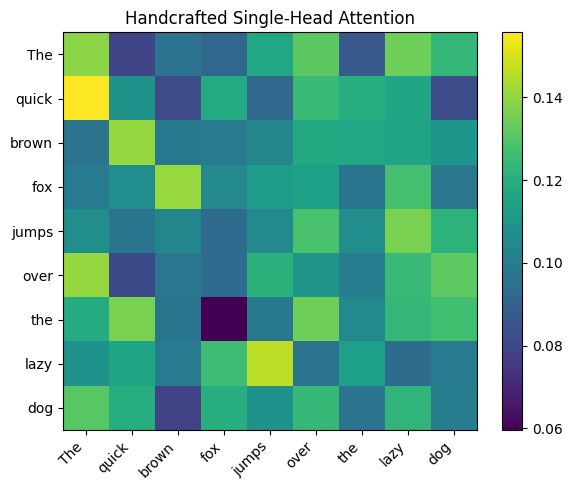

In [2]:
# 1) Handcrafted single-head attention (for baseline)
import numpy as np
import math

n_tokens = len(tokens)
d_model = 64

# Random embeddings
embeddings = np.random.randn(n_tokens, d_model) * 0.5

# Random linear projections
W_q = np.random.randn(d_model, d_model) * 0.1
W_k = np.random.randn(d_model, d_model) * 0.1
W_v = np.random.randn(d_model, d_model) * 0.1

Q = embeddings @ W_q
K = embeddings @ W_k
V = embeddings @ W_v

scores = Q @ K.T / math.sqrt(d_model)
attn_single = softmax(scores, axis=-1)
context_single = attn_single @ V

print('Single-head attention shape:', attn_single.shape)
plot_attention_matrix(attn_single, tokens, title='Handcrafted Single-Head Attention')


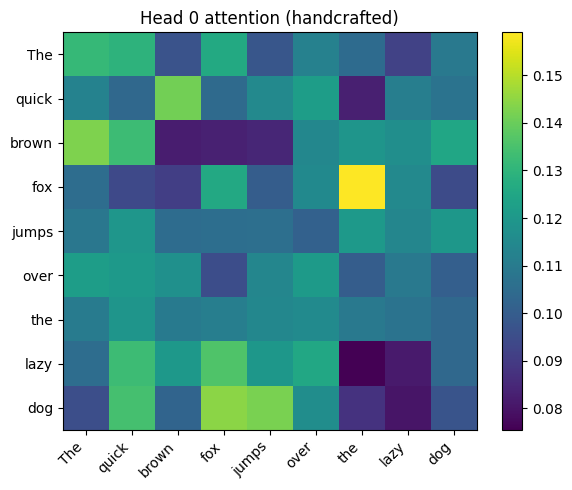

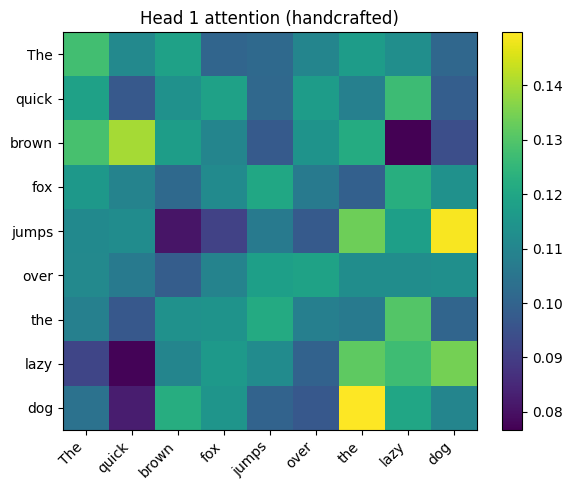

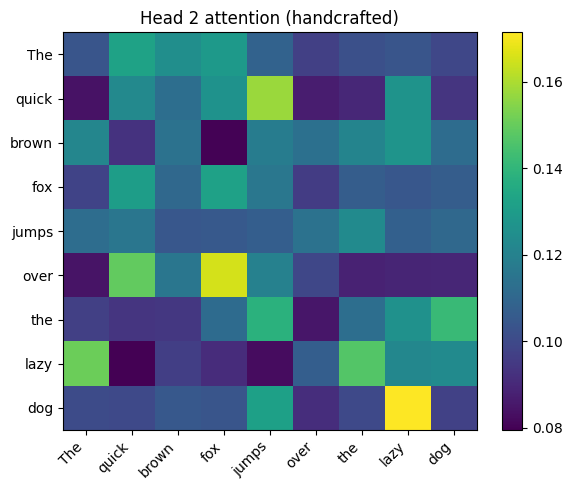

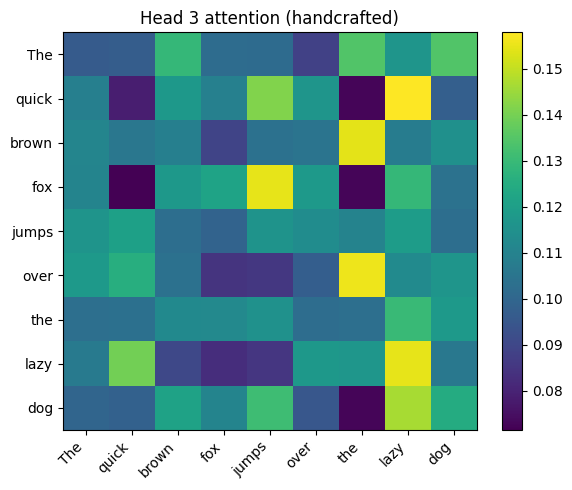

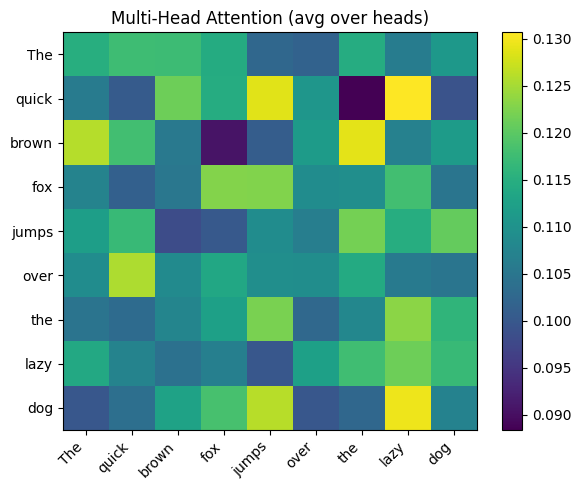

Multi-head heads_attn shape: (4, 9, 9)


In [3]:
# 2) Handcrafted multi-head attention (NumPy)
# We'll split d_model into num_heads heads, each with dim d_k = d_model/num_heads
num_heads = 4
assert d_model % num_heads == 0

d_k = d_model // num_heads

# Create separate projection matrices per head (small random init)
W_qh = np.random.randn(num_heads, d_model, d_k) * 0.1
W_kh = np.random.randn(num_heads, d_model, d_k) * 0.1
W_vh = np.random.randn(num_heads, d_model, d_k) * 0.1

# For each head compute Q,K,V and attention
heads_attn = np.zeros((num_heads, n_tokens, n_tokens))
heads_context = np.zeros((num_heads, n_tokens, d_k))

for h in range(num_heads):
    Qh = embeddings @ W_qh[h]  # (n_tokens, d_k)
    Kh = embeddings @ W_kh[h]
    Vh = embeddings @ W_vh[h]
    scores_h = Qh @ Kh.T / math.sqrt(d_k)
    attn_h = softmax(scores_h, axis=-1)
    ctx_h = attn_h @ Vh
    heads_attn[h] = attn_h
    heads_context[h] = ctx_h
    plot_attention_matrix(attn_h, tokens, title=f'Head {h} attention (handcrafted)')

# Concatenate contexts from all heads and project (simulate output linear layer)
concat_ctx = heads_context.reshape(n_tokens, num_heads * d_k)
W_o = np.random.randn(num_heads * d_k, d_model) * 0.1
context_multi = concat_ctx @ W_o  # (n_tokens, d_model)

# Aggregate attention: average across heads
attn_multi_avg = heads_attn.mean(axis=0)
plot_attention_matrix(attn_multi_avg, tokens, title='Multi-Head Attention (avg over heads)')

print('Multi-head heads_attn shape:', heads_attn.shape)


In [4]:
# 3) Comparison metrics between single-head and multi-head
# Metric 1: correlation between flattened attention matrices
single_flat = attn_single.flatten()
multi_flat = attn_multi_avg.flatten()
from scipy.stats import pearsonr
corr_flat, _ = pearsonr(single_flat, multi_flat)

# Metric 2: average neighbor vs far attention (distance-based)
def neighbor_vs_far(attn):
    seq_len = attn.shape[0]
    neigh = []
    far = []
    for i in range(seq_len):
        for j in range(seq_len):
            if i==j: continue
            if abs(i-j)==1:
                neigh.append(attn[i,j])
            elif abs(i-j)>2:
                far.append(attn[i,j])
    return np.mean(neigh), np.mean(far)

s_neigh, s_far = neighbor_vs_far(attn_single)
m_neigh, m_far = neighbor_vs_far(attn_multi_avg)

results = pd.DataFrame({
    'Setting':['Single-Head','Multi-Head (avg)'],
    'AvgNeighbor':[s_neigh, m_neigh],
    'AvgFar':[s_far, m_far],
    'FlattenCorr':[corr_flat, np.nan]
})

results


,Setting,AvgNeighbor,AvgFar,FlattenCorr
0,Single-Head,0.115467,0.112022,-0.182937
1,Multi-Head (avg),0.112579,0.110451,NaN


Raw attn_weights shape from PyTorch: torch.Size([1, 9, 9])


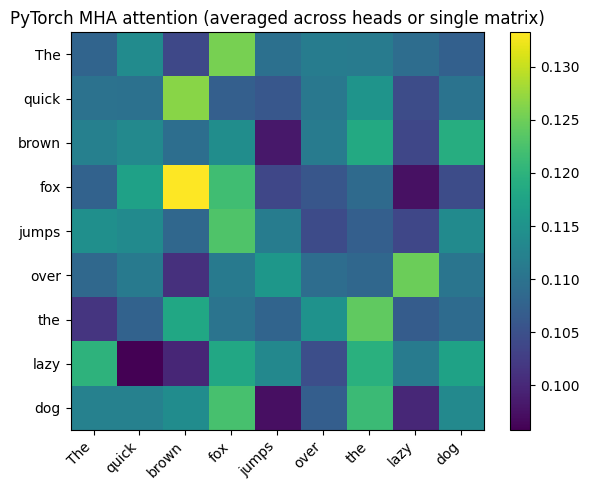

In [5]:
# 4) Optional: PyTorch nn.MultiheadAttention (reference implementation)
try:
    import torch
    import torch.nn as nn
    
    # Prepare inputs: nn.MultiheadAttention expects (seq_len, batch, embed_dim)
    embed_dim = d_model
    mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=False)
    
    # Convert embeddings to torch tensor
    emb_t = torch.tensor(embeddings, dtype=torch.float32)  # (seq_len, d_model)
    emb_t = emb_t.unsqueeze(1)  # (seq_len, batch=1, d_model)

    # nn.MultiheadAttention returns attn_output and attn_output_weights (if need_weights=True)
    mha.eval()
    with torch.no_grad():
        out, attn_weights = mha(emb_t, emb_t, emb_t, need_weights=True)
    # attn_weights shape: (batch, seq_len, seq_len) if average_heads=False in PyTorch older versions returns (batch*num_heads, seq_len, seq_len)
    # Newer versions return (batch, num_heads, seq_len, seq_len) if need_weights and average_heads=False isn't set; to be safe, inspect shape
    aw = attn_weights
    print('Raw attn_weights shape from PyTorch:', aw.shape)
    
    # Try to massage into (num_heads, seq_len, seq_len)
    aw_np = aw.numpy()
    if aw_np.ndim == 3:
        # shape (seq_len, seq_len, ) or (batch, seq_len, seq_len)
        if aw_np.shape[0] == 1 or aw_np.shape[0] == emb_t.shape[1]:
            # (batch, seq_len, seq_len)
            aw_np = aw_np[0]
        # No head dimension: PyTorch averaged across heads by default in some versions
        # We'll just visualize this as a reference
        plot_attention_matrix(aw_np, tokens, title='PyTorch MHA attention (averaged across heads or single matrix)')
    elif aw_np.ndim == 4:
        # (batch, num_heads, seq_len, seq_len)
        aw_heads = aw_np[0]
        for h in range(min(num_heads, aw_heads.shape[0])):
            plot_attention_matrix(aw_heads[h], tokens, title=f'PyTorch MHA head {h} attention')
        # Average across heads
        aw_avg = aw_heads.mean(axis=0)
        plot_attention_matrix(aw_avg, tokens, title='PyTorch MHA average attention across heads')
    else:
        print('Unexpected attn_weights shape:', aw_np.shape)

    torch_results = {'aw_np': aw_np}

except Exception as e:
    print('PyTorch MultiheadAttention not available or failed to run in this environment.')
    print('Error:', e)
    print('\nIf running locally, install torch with: pip install torch')



In [6]:
# 5) Summary observations
print('Metrics table from earlier:')
print(results.to_string(index=False))

print('\nObservations:')
print('- Multi-head attention shows per-head attention matrices (visualized above). Averaging across heads gives an overall attention pattern comparable to single-head but can differ significantly in where heads attend.')
print('- The Pearson correlation (flattened mat) between single-head and averaged multi-head attention provides a quantitative summary of similarity.')
print('- Head-wise visualizations help identify if certain heads focus on local vs. long-range context.')


Metrics table from earlier:
         Setting  AvgNeighbor   AvgFar  FlattenCorr
     Single-Head     0.115467 0.112022    -0.182937
Multi-Head (avg)     0.112579 0.110451          NaN

Observations:
- Multi-head attention shows per-head attention matrices (visualized above). Averaging across heads gives an overall attention pattern comparable to single-head but can differ significantly in where heads attend.
- The Pearson correlation (flattened mat) between single-head and averaged multi-head attention provides a quantitative summary of similarity.
- Head-wise visualizations help identify if certain heads focus on local vs. long-range context.


## Next steps
- Try increasing number of heads and inspecting specialized head behavior.
- Replace random embeddings with pretrained embeddings (wordpieces) and use a real transformer to inspect learned attention.
- Implement attention rollout (Abnar & Zuidema) to see cumulative cross-layer effects.
